In [1]:
from pathlib import Path
import re
from stitching import Stitcher
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import time
import glob
from reolink_api_client import ReolinkAPIClient

In [2]:
# -------- helpers --------
def pose_num(path):
    m = re.search(r"pose_(\d+)", path.stem)
    return int(m.group(1)) if m else 0

def to_pil_rgb(img):
    # library may return numpy array in BGR
    if isinstance(img, np.ndarray):
        if img.ndim == 3 and img.shape[2] == 3:
            img = img[:, :, ::-1]
        return Image.fromarray(img)
    return img  # already PIL

In [3]:
# ---------- helpers ----------
def load_bgr(path):
    im = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if im is None:
        raise FileNotFoundError(str(path))
    return im

def select_subset_by_stride(paths, stride=2):
    return paths[::max(1, int(stride))]

def select_subset_by_redundancy(paths, min_shift_px=400, min_inliers=60, max_size=960):
    """
    Keep the first image. For each next candidate, match to the last kept image at small size,
    estimate homography, and discard if the image center shift is small.
    """
    if not paths:
        return []
    kept = [paths[0]]
    # prepare ORB for speed
    orb = cv2.ORB_create(nfeatures=4000)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    def resize_keep_aspect(img, max_w=max_size):
        h, w = img.shape[:2]
        if w <= max_w:
            return img, 1.0
        s = max_w / float(w)
        new = cv2.resize(img, (max_w, int(h * s)), interpolation=cv2.INTER_AREA)
        return new, s

    def keydesc(img):
        k, d = orb.detectAndCompute(img, None)
        return k, d

    last_img = load_bgr(kept[-1])
    last_small, s_last = resize_keep_aspect(last_img)
    k_last, d_last = keydesc(last_small)

    for p in paths[1:]:
        img = load_bgr(p)
        small, s = resize_keep_aspect(img)
        k, d = keydesc(small)
        if d is None or d_last is None or len(k) < 10 or len(k_last) < 10:
            kept.append(p)
            last_small, k_last, d_last = small, k, d
            continue

        # knn matches and ratio test
        raw = bf.knnMatch(d, d_last, k=2)
        good = [m for m, n in raw if m.distance < 0.75 * n.distance]
        if len(good) < min_inliers:
            kept.append(p)
            last_small, k_last, d_last = small, k, d
            continue

        # homography and center shift
        src = np.float32([k[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst = np.float32([k_last[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 3.0)
        if H is None:
            kept.append(p)
            last_small, k_last, d_last = small, k, d
            continue

        h, w = small.shape[:2]
        center = np.array([[[w * 0.5, h * 0.5]]], dtype=np.float32)
        ctr_warp = cv2.perspectiveTransform(center, H)[0, 0]
        shift = float(np.linalg.norm(ctr_warp - center[0, 0]))
        if shift >= min_shift_px * (small.shape[1] / max_size):
            kept.append(p)
            last_small, k_last, d_last = small, k, d
        # else, skip as redundant

    return kept

In [4]:

MIN_INLIERS = 20
RANSAC_THRESH = 3.0


def match_knn(desc1, desc2):
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=100)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = matcher.knnMatch(desc1, desc2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    return good

def find_homography(kp1, kp2, matches, ransac_thresh=3.0):
    if len(matches) < 12:
        return None, 0, None, None, None, None
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_thresh)
    if H is None or mask is None:
        return None, 0, None, None, None, None
    inliers = mask.ravel().astype(bool)
    n_in = int(inliers.sum())
    src_in = src_pts[inliers]
    dst_in = dst_pts[inliers]
    proj = cv2.perspectiveTransform(src_in, H)
    err = np.linalg.norm(proj - dst_in, axis=2)
    rms = float(np.sqrt((err ** 2).mean()))
    return H, n_in, rms, src_pts, dst_pts, inliers

def draw_projection_on_pano(pano_bgr, src_shape, H):
    h, w = src_shape[:2]
    corners = np.float32([[0,0],[w-1,0],[w-1,h-1],[0,h-1]]).reshape(-1,1,2)
    proj = cv2.perspectiveTransform(corners, H).reshape(-1,2)
    xs = proj[:,0]; ys = proj[:,1]
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    cx = 0.5 * (x_min + x_max)
    cy = 0.5 * (y_min + y_max)
    return (cx, cy), (x_min, y_min, x_max, y_max), proj

def az_from_x_simple(x, img_width_px, ref_azimuth, ref_pixel, fov_deg):
    px_per_deg = img_width_px / float(fov_deg)
    az = ref_azimuth + (float(x) - ref_pixel) / px_per_deg
    return az % 360.0

In [5]:
# -------- config --------

detector = "sift"               # "sift" is robust, "orb" is faster
confidence_threshold = 0.35      # relax if you see gaps
try_affine_fallback = True      # try a gentler affine model if the default fails
max_width_px = None             # set for downscale, for example 8000, or keep None
FOV_DEG = 54.2


In [6]:
PI_IP = "192.168.255.26"
cams = glob.glob(f"captures/{PI_IP}/*")
cams

['captures/192.168.255.26/169.254.40.1',
 'captures/192.168.255.26/169.254.40.3']

In [7]:
# Pick cam index 

idx = 0

cam = cams[idx].split('/')[-1]
folder = Path(f"captures/{PI_IP}") / f"{cam}/images"
print(folder)


captures/192.168.255.26/169.254.40.1/images


captures/192.168.255.26/169.254.40.1/panorama_full.jpg


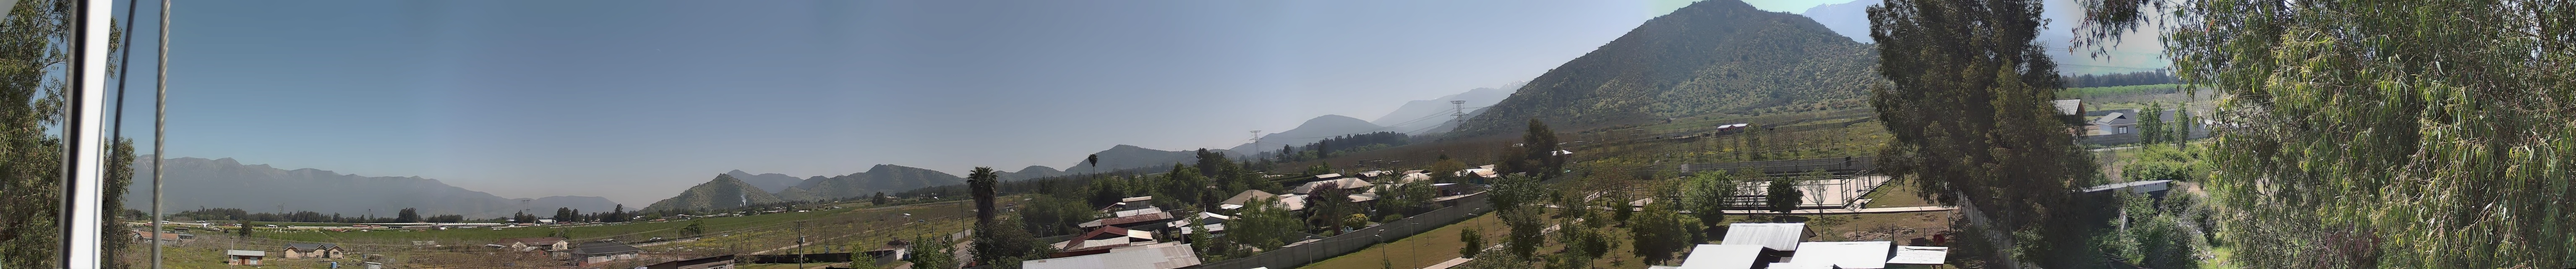

In [8]:
output_dir = folder.parent
panorama_path = output_dir / "panorama_full.jpg"

print(panorama_path)

Image.open(panorama_path)

In [9]:
# Now Select a reference point

In [10]:
# If sun is visible you can use :

# import datetime
# from pysolar.solar import get_azimuth

# lat = 44.2008
# lon = 3.1409
# date = datetime.datetime(2025, 10, 13, 17, 24, 00, tzinfo=datetime.timezone.utc)

# real_sun_azimuth = get_azimuth(lat, lon, date)
# real_sun_azimuth

In [11]:
ref_azimuth = 20.9
ref_pixel = 1716

In [12]:
paths = [p for p in folder.glob("*.jpg")]
paths = sorted(paths, key=pose_num)

In [13]:
# ---------- main loop ----------
pano = load_bgr(panorama_path)
extractor = cv2.SIFT_create(nfeatures=6000)

# Use the first image width for approximate scale
first_img = load_bgr(paths[0])

img_width_px = first_img.shape[1]

rows = []
skipped = []

for p in paths:
    try:
        src = load_bgr(p)
        kp_src, des_src = extractor.detectAndCompute(src, None)
        kp_pano, des_pano = extractor.detectAndCompute(pano, None)
        if des_src is None or des_pano is None or len(kp_src) < 8 or len(kp_pano) < 8:
            skipped.append((p.name, "few features"))
            continue

        good = match_knn(des_src, des_pano)

        H, n_in, rms, *_ = find_homography(kp_src, kp_pano, good)
        if H is None or n_in < MIN_INLIERS:
            skipped.append((p.name, f"{n_in} inliers"))
            continue

        center, bbox, _ = draw_projection_on_pano(pano, src.shape, H)
        cx, cy = center

        az_center = az_from_x_simple(cx, img_width_px, ref_azimuth, ref_pixel, FOV_DEG)

        rows.append(dict(
            pose=pose_num(p),
            name=p.name,
            cx=cx,
            cy=cy,
            az_center=az_center,
            inliers=n_in,
            rms=rms
        ))
    except Exception as e:
        print(e)
        skipped.append((p.name, str(e)))

df = pd.DataFrame(rows).sort_values("pose").reset_index(drop=True)

print(f"Valid poses: {len(df)} of {len(paths)}")
if skipped:
    print("Skipped poses:")
    for n, why in skipped:
        print(f"  {n}: {why}")

if len(df):
    print("\n=== Per pose results ===")
    print(df.to_string(index=False, formatters={
        "cx": "{:.1f}".format,
        "cy": "{:.1f}".format,
        "az_center": "{:.2f}".format,
        "rms": "{:.3f}".format
    }))

    print("\n=== Summary ===")
    print(f"Image width used for scale: {img_width_px}px  FOV={FOV_DEG}°")
    print(f"Approx deg per px: {FOV_DEG / img_width_px:.6f}")

    print("\nCalibration reference:")
    print(f"ref_pixel = {ref_pixel}px  ref_azimuth = {ref_azimuth}°")


Valid poses: 13 of 19
Skipped poses:
  pose_30.jpg: 16 inliers
  pose_43.jpg: 19 inliers
  pose_44.jpg: 6 inliers
  pose_45.jpg: 0 inliers
  pose_46.jpg: 0 inliers
  pose_47.jpg: 4 inliers

=== Per pose results ===
 pose        name     cx    cy az_center  inliers   rms
   31 pose_31.jpg   44.6 332.3    310.12       75 1.219
   32 pose_32.jpg  609.3 312.2    334.04      168 1.276
   33 pose_33.jpg 1094.5 314.6    354.58      101 0.811
   34 pose_34.jpg 1646.9 246.6     17.97       80 1.130
   35 pose_35.jpg 2000.0 282.1     32.93       60 1.044
   36 pose_36.jpg 2515.6 295.0     54.76      135 0.622
   37 pose_37.jpg 3030.7 288.4     76.57      173 1.260
   38 pose_38.jpg 3582.5 322.7     99.94      141 0.886
   39 pose_39.jpg 4052.6 320.5    119.84      176 1.354
   40 pose_40.jpg 4565.5 323.1    141.56      308 0.846
   41 pose_41.jpg 5090.3 297.8    163.78      136 1.448
   42 pose_42.jpg 5536.3 307.6    182.66     1238 1.419
   48 pose_48.jpg  -59.8 301.2    305.71       38 0.579



In [39]:
df.to_csv(output_dir / "calibration.csv")

In [ ]:
# Then select the poses you cant to keep

In [ ]:
# selected_poses = [32,34,36,38,40]

In [ ]:

# API_BASE = f"http://{PI_IP}:8081"
# client = ReolinkAPIClient(API_BASE)
# SPEED_LEVEL = 50

In [36]:
# client.stop_patrol(cam)
# client.move_camera(cam, pose_id=selected_poses[0], speed=SPEED_LEVEL)
# time.sleep(3)
# for idx, pose in enumerate(selected_poses):
#     client.move_camera(cam, pose_id=pose, speed=SPEED_LEVEL)
#     time.sleep(2)
#     print(f"Setting on cam {cam} pose {idx}")
#     client.set_preset(cam, idx)
